В этой задаче мы попытаемся сгенерировать sure cleared_sentences, используя различные рекуррентные нейронные сети

# Data preparation

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython.display import clear_output
from random import sample,shuffle
from tqdm import tqdm
from string import punctuation
from nltk.translate.bleu_score import corpus_bleu
%matplotlib inline

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv("df_total.csv")

In [ ]:
sentences = list((df["Обычный"] + " <CL> " + df["Ясный"]).values)

In [ ]:
sentences[1]

'Сегодня утром ко мне пришла соседка. Она попросила соль. <CL> Соседка пришла ко мне сегодня утром, попросив соль.'

In [ ]:
len(sentences)

1276

In [ ]:
def prepare_sentance(s):
  max_len = 70
  s = s.lower()
  for punct in punctuation:
    s = s.replace(punct,"",len(s))
  s = s.replace("\n","",len(s))
  s = "<SOS> " + s
  while "  " in s:
    s = s.replace("  "," ",len(s))
  s = " ".join(s.split()[:max_len])
  return s

In [ ]:
cleared_sentences = list(map(prepare_sentance,sentences))
shuffle(cleared_sentences)
cleared_sentences_len = len(cleared_sentences)

In [ ]:
test_data,train_data = cleared_sentences[:round(cleared_sentences_len*0.1)],cleared_sentences[round(cleared_sentences_len*0.1):]

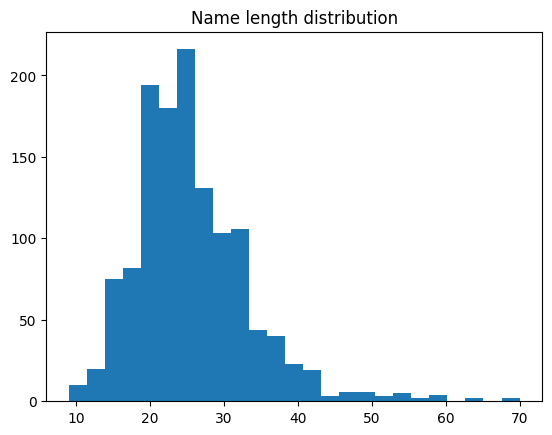

In [ ]:
plt.title('Name length distribution')
plt.hist(list(map(lambda cleared_sentence: len(cleared_sentence.split()), cleared_sentences)), bins=25);

In [ ]:
tokens = []
for cleared_sentence in cleared_sentences:
  tokens += cleared_sentence.split()
tokens = list(set(tokens)) + ["<EOS>"]
num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  7079


In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [ ]:
def to_matrix(data, token_to_id,max_len=150, dtype='int32', batch_first = True):
    """Casts a list of cleared_sentences into rnn-digestable matrix"""
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id["<EOS>"]
    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i].split()]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
MAX_LENGTH = max(map(lambda sent: len(sent.split()), cleared_sentences))

In [ ]:
class CLDataset(torch.utils.data.Dataset):
  def __init__(self, x, token_to_id,max_len=None):
    self.x = x
    self.token_to_id = token_to_id
    self.max_len = max_len
  def __len__(self):
    return len(self.x)
  def __getitem__(self, idx):
    return torch.tensor(to_matrix([self.x[idx]], self.token_to_id, self.max_len), dtype=torch.int64)[0]

In [ ]:
dataset = CLDataset(train_data,token_to_id, 150)

In [ ]:
dl = torch.utils.data.DataLoader(dataset,batch_size=64, shuffle=True)

# classic RNN

In [ ]:
class sentRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=100, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, 3, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        #assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

rnn_model = sentRNNLoop().to(device)
opt = torch.optim.Adam(rnn_model.parameters())
history = []


In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchviz import make_dot

make_dot(rnn_model.forward(torch.Tensor([[7078,7078,7078]]).long().to(device)), params=dict(list(rnn_model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [ ]:
MAX_LENGTH = max(map(lambda sent: len(sent.split()), cleared_sentences))
def train_model(model,data,token_to_id,epochs,max_len, device=None):
    if device is None:
      device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    for i in tqdm(range(epochs)):
      for j, batch_ix in enumerate(data):
        batch_ix = batch_ix.to(device)

        logp_seq = model(batch_ix)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.cpu().numpy())
        if (j + 1) % 100 == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()

    assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [ ]:
train_model(model=rnn_model,data = dl,token_to_id = token_to_id,epochs=300,max_len=MAX_LENGTH)

100%|██████████| 300/300 [02:58<00:00,  1.68it/s]


In [ ]:
def generate_sample(model, seed_phrase=None, max_length=MAX_LENGTH, temperature=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    if seed_phrase is None:
      seed_phrase = "<SOS>"
    input = torch.LongTensor([token_to_id[l] for l in seed_phrase.split()])
    start_len = len(input)
    for i in range(max_length-start_len):
      raw_output = model(input)
      p_next = F.softmax(raw_output[-1] / temperature, dim=-1).data.numpy()
      next_ix = np.random.choice(len(tokens),p=p_next)
      input = torch.cat([input, torch.LongTensor([next_ix])])
    result =  ' '.join([tokens[ix] for ix in input])
    return result.replace(" <EOS>","",len(result))
    #return result.replace("<SOS> ","").replace(" <EOS>","",len(result))

In [ ]:
rnn_model.to("cpu")

sentRNNLoop(
  (emb): Embedding(7079, 100)
  (rnn): RNN(100, 64, num_layers=3, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=7079, bias=True)
)

In [ ]:
for _ in range(3):
  print(generate_sample(rnn_model,seed_phrase="кошелек потерял нужно найти его cl", temperature = 0.9))
  print("_"*150)

кошелек потерял нужно найти его ради cl я не домашнее и поражен белых работу в лесу кончилось новый заменить cl семья готовки явлением и у их все его друзья всей пути на время но нас стало порошок она тратить её проблему заказали металлическую лестницу
______________________________________________________________________________________________________________________________________________________
кошелек потерял нужно найти его некоторое вечер cl мои отсутствия штору но обнаружив что не было пошли на день своим более вещей cl даша подумал завтрак днем в магазин
______________________________________________________________________________________________________________________________________________________
кошелек потерял нужно найти его страшные решила уборку новую работу но забыла кошелек и оказался принес по покупки cl когда прочитал маской любимой обработки закат их чтобы стоило заменить cl на утро валерий успели зависть день
_________________________________________________

In [ ]:
def evalueate_model(model, ref_data, temperature = 1, samples_num = 10):
  references = list(map(lambda s: s.split(),ref_data))
  return [corpus_bleu([references], [generate_sample(model,temperature=temperature).split()])
          for _ in tqdm(range(samples_num))]

In [ ]:
rnn_result = evalueate_model(rnn_model,test_data, temperature = 0.6)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
 40%|████      | 4/10 [00:01<00:01,  3.53it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it cont

In [ ]:
sum(rnn_result)/10

0.05939047365171549

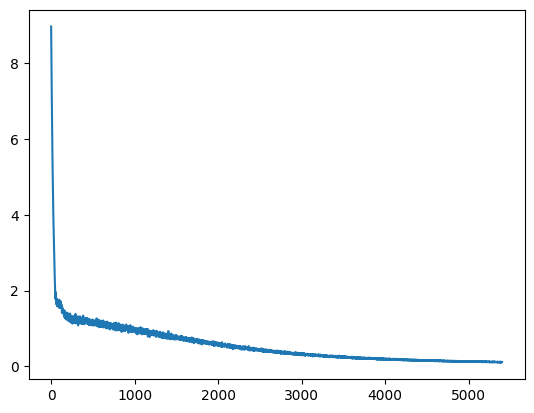

In [ ]:
plt.plot(history)

# GRU and LSTM RNN

In [ ]:
class sentLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=1000, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn1 = nn.GRU(emb_size, rnn_num_units, 2, batch_first=True)
        self.rnn2 = nn.LSTM(rnn_num_units, rnn_num_units,1, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        #assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn1(self.emb(x))
        h_seq, _ = self.rnn2(h_seq)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

lstm_model = sentLSTMLoop().to(device)
opt = torch.optim.Adam(lstm_model.parameters())
history = []

In [ ]:
make_dot(lstm_model.forward(torch.Tensor([[7078,7078,7078]]).long().to(device)), params=dict(list(lstm_model.named_parameters()))).render("lstm_torchviz", format="png")

'lstm_torchviz.png'

In [ ]:
train_model(model=lstm_model,data = dl,token_to_id = token_to_id,epochs=500,max_len=70)

100%|██████████| 500/500 [05:49<00:00,  1.43it/s]


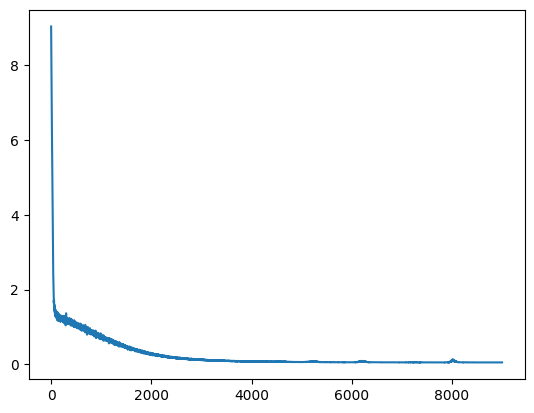

In [ ]:
plt.plot(history)

In [ ]:
lstm_model.to("cpu")

sentLSTMLoop(
  (emb): Embedding(7079, 1000)
  (rnn1): GRU(1000, 64, batch_first=True)
  (rnn2): LSTM(64, 64, batch_first=True)
  (hid_to_logits): Linear(in_features=64, out_features=7079, bias=True)
)

In [ ]:
for _ in range(3):
  print(generate_sample(lstm_model, seed_phrase="я сегодня попросил выходной чтобы посетить свою бабушку в другом городе cl",temperature = 0.9))
  print("_"*150)

я сегодня попросил выходной чтобы посетить свою бабушку в другом городе cl москитным углы выключить когда нужно купить cl нужно купить новые зубной порошок ей попыталась
______________________________________________________________________________________________________________________________________________________
я сегодня попросил выходной чтобы посетить свою бабушку в другом городе cl блюдо я немного ушла у нее из метро но это было обойтись обед из нее нет к проросла надевать cl коллеги помощь сама к
______________________________________________________________________________________________________________________________________________________
я сегодня попросил выходной чтобы посетить свою бабушку в другом городе cl порядок работой я сделал пришлось готовить ужин пришлось микроволновку ездить обувь окно чтобы следующий по утро игре cl я приготовила сделала комнаты но ее блюда которое пиццу по попала сгорел заказали дождь как заказали что заказали пиццу на ужин но забыл по

In [ ]:
lstm_result = evalueate_model(lstm_model,test_data,temperature = 0.3)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


In [ ]:
sum(lstm_result)/10

0.043773493813260435